In [1]:
from keras.layers import  TextVectorization
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import FeatureSpace
from keras.ops import transpose
from keras_rs.layers import BruteForceRetrieval
from keras_rs.metrics import MeanReciprocalRank, MeanAveragePrecision, NDCG
from keras_rs.losses import PairwiseHingeLoss

import collections
from pprint import pprint
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"  # `"tensorflow"`/`"torch"`

2025-05-30 20:11:50.412191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 20:11:50.437808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 20:11:50.475160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748628710.508475   41571 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748628710.517899   41571 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748628710.562393   41571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
df = pd.read_csv("../data/dq_recsys_challenge_2025(in).csv")

In [3]:
df['int_date'] = pd.to_datetime(df['int_date'], format='%d-%b-%y')

In [4]:
for i in df.columns:
    print(i, df[i].isna().sum())

df['int_date'] = pd.to_datetime(df['int_date'], format='%d-%b-%y', errors='coerce')

idcol 0
interaction 0
int_date 0
item 0
page 0
tod 0
item_type 0
item_descrip 173638
segment 0
beh_segment 0
active_ind 0


In [5]:
df.sort_values(by=["int_date", "idcol"], inplace=True)

In [6]:
df['id'] = df['idcol']
df['day'] = df['int_date'].dt.day.astype(float)
df['day_of_week'] = df['int_date'].dt.dayofweek.astype(float)
df['month'] = df['int_date'].dt.month.astype(float)
df.dropna(subset=['item_descrip'], inplace=True)
df = df[df['interaction'].isin(['CLICK', 'CHECKOUT'])]
df.reset_index(drop=True, inplace=True)

df['active_ind'] = df['active_ind'].astype('category').cat.codes
df['segment'] = df['segment'].astype('category').cat.codes
df['beh_segment'] = df['beh_segment'].astype('category').cat.codes
df['tod'] = df['tod'].astype('category').cat.codes
df['interaction'] = df['interaction'].astype('category').cat.codes
df['page'] = df['page'].astype('category').cat.codes
df['item_type'] = df['item_type'].astype('category').cat.codes


In [7]:
df

,idcol,interaction,int_date,item,page,tod,item_type,item_descrip,segment,beh_segment,active_ind,id,day,day_of_week,month
0,73205,1,2023-01-01,EBEM,1,0,4,EBUCKS EARN MORE,0,0,0,73205,1.0,6.0,1.0
1,73205,0,2023-01-01,EBEM,1,0,4,EBUCKS EARN MORE,0,0,0,73205,1.0,6.0,1.0
2,166578,1,2023-01-01,IBGC,0,0,1,FNB GAP COVER,3,0,2,166578,1.0,6.0,1.0
3,166578,0,2023-01-01,IBGC,0,0,1,FNB GAP COVER,3,0,2,166578,1.0,6.0,1.0
4,258838,1,2023-01-01,CARE,0,3,3,RF LIMIT INCREASE,2,0,0,258838,1.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226357,25395174118,1,2023-03-31,CBPA,0,3,0,PREPAID AIRTIME - OFFER,0,1,0,25395174118,31.0,4.0,3.0
226358,25427267018,1,2023-03-31,CBPA,0,1,0,PREPAID AIRTIME - OFFER,0,0,2,25427267018,31.0,4.0,3.0
226359,25585786218,1,2023-03-31,CUHS,0,3,2,HORIZON SERIES,1,18,2,25585786218,31.0,4.0,3.0
226360,25603480118,1,2023-03-31,CTLN,0,0,3,DDA TEMP LOANS BATCH,0,42,2,25603480118,31.0,4.0,3.0


In [8]:
df.drop(columns=["int_date"],axis=1, inplace=True)
df.drop(columns=["idcol"],axis=1, inplace=True)

In [9]:
df.insert(0, 'id', df.pop('id'))

In [10]:
df.isna().any().any()

np.False_

In [11]:
columns = df.columns.to_list()
columns

['id',
 'interaction',
 'item',
 'page',
 'tod',
 'item_type',
 'item_descrip',
 'segment',
 'beh_segment',
 'active_ind',
 'day',
 'day_of_week',
 'month']

In [12]:

id_col = ['id']
user_features = ['active_ind', 'segment', 'beh_segment', 'tod', 'day', 'day_of_week', 'month']
item_features = ['item', 'item_descrip', 'page', 'interaction']

id_df = df[id_col]
user_df = df[user_features]
item_df = df[item_features]


In [13]:
dataset = tf.data.Dataset.from_tensor_slices(df.to_dict(orient='list'))

2025-05-30 20:11:55.915510: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
user_id_col = 'id'
item_id_col = 'item'
unique_user_ids = df[user_id_col].unique()
user_id_lookup = tf.keras.layers.IntegerLookup(mask_token=None)
user_id_lookup.adapt(tf.constant(unique_user_ids))
USERS_VOCAB_SIZE = user_id_lookup.vocabulary_size()

In [15]:
unique_item_ids = df[item_id_col].unique()
item_id_lookup = tf.keras.layers.StringLookup(mask_token=None)
item_id_lookup.adapt(tf.constant(unique_item_ids))
ITEMS_VOCAB_SIZE = item_id_lookup.vocabulary_size()

In [16]:
item_description_vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=16, output_mode='int')
unique_items_df = df[[item_id_col, 'item_descrip']].drop_duplicates()
item_description_vectorizer.adapt(unique_items_df['item_descrip'])
ITEM_DESCRIPTION_COUNT = item_description_vectorizer.vocabulary_size()


In [17]:
feature_space = FeatureSpace(
    features={
        'active_ind': FeatureSpace.integer_categorical(num_oov_indices=1, output_mode='int'), 
        'segment': FeatureSpace.integer_categorical(num_oov_indices=1, output_mode='int'),    
        'beh_segment': FeatureSpace.integer_categorical(num_oov_indices=1, output_mode='int'), 
        'tod': FeatureSpace.integer_categorical(num_oov_indices=1, output_mode='int'),        
        'page': FeatureSpace.integer_categorical(num_oov_indices=1, output_mode='int'),      
        'day': FeatureSpace.float_normalized(),
        'day_of_week': FeatureSpace.float_normalized(),
        'month': FeatureSpace.float_normalized()
    },
    output_mode="dict"
)

candidate_dataset = {
    "item_id": tf.cast(item_id_lookup(tf.constant(unique_items_df[item_id_col].values)), tf.int32),
    "item_descrip_vector": tf.cast(item_description_vectorizer(tf.constant(unique_items_df['item_descrip'].values)), tf.int32)
}


USERS_COUNT = df['id'].nunique()
ITEMS_COUNT = df['item'].nunique()

In [18]:
interaction_dataset_raw = tf.data.Dataset.from_tensor_slices(df.to_dict(orient='list'))
dataset_size = df.shape[0]
train_size = int(0.8 * dataset_size)
train_interaction_dataset_raw = interaction_dataset_raw.take(train_size)
test_interaction_dataset_raw = interaction_dataset_raw.skip(train_size)

In [19]:
def extract_features_for_fs_adapt(record):
    keys = list(feature_space.features.keys())
    return {k: record[k] for k in keys}

train_data_for_fs_adapt = train_interaction_dataset_raw.map(extract_features_for_fs_adapt)
feature_space.adapt(train_data_for_fs_adapt)

2025-05-30 20:12:07.538537: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-30 20:12:13.017309: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-30 20:12:24.365127: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-30 20:13:09.560400: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
feature_space_feature_names = list(feature_space.features.keys())

def preprocess_interaction_for_model(interaction_record):
    fs_input = {k: interaction_record[k] for k in feature_space_feature_names}
    processed_features = feature_space(fs_input)
    query_inputs = {
        "user_id": user_id_lookup(interaction_record[user_id_col]),
        **processed_features
    }
    candidate_inputs = {
        "item_id": item_id_lookup(interaction_record[item_id_col]),
        "item_descrip_vector": item_description_vectorizer(interaction_record["item_descrip"])
    }
    target_label = item_id_lookup(interaction_record[item_id_col])
    all_inputs = {**query_inputs, **candidate_inputs}
    return all_inputs, target_label

BATCH_SIZE = 128
train_dataset = train_interaction_dataset_raw.map(preprocess_interaction_for_model).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_interaction_dataset_raw.map(preprocess_interaction_for_model).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
class QueryModel(tf.keras.Model):
    def __init__(self, dense_units=[64, 32]):
        super().__init__()
        self.embedding_dimension = 32 
        self.categorical_embedding_dimension = 16 

        self.user_embedding = tf.keras.layers.Embedding(USERS_VOCAB_SIZE, self.embedding_dimension)
        self.active_ind_embedding = tf.keras.layers.Embedding(feature_space.preprocessors['active_ind'].vocabulary_size(), self.categorical_embedding_dimension)
        self.segment_embedding = tf.keras.layers.Embedding(feature_space.preprocessors['segment'].vocabulary_size(), self.categorical_embedding_dimension)
        self.beh_segment_embedding = tf.keras.layers.Embedding(feature_space.preprocessors['beh_segment'].vocabulary_size(), self.categorical_embedding_dimension)
        self.tod_embedding = tf.keras.layers.Embedding(feature_space.preprocessors['tod'].vocabulary_size(), self.categorical_embedding_dimension)
        self.page_embedding = tf.keras.layers.Embedding(feature_space.preprocessors['page'].vocabulary_size(), self.categorical_embedding_dimension)

        self.dense_layers = tf.keras.Sequential([tf.keras.layers.Dense(u, activation='relu') for u in dense_units])

    def build(self, input_shape):
        concat_size = (
            self.embedding_dimension +  
            self.categorical_embedding_dimension * 5 + # active_ind, segment, beh_segment, tod, page embeddings
            len(['day', 'day_of_week', 'month']) 
        )
        self.dense_layers.build((None, concat_size)) 


        super().build(input_shape)


    def call(self, inputs):
        user_emb = self.user_embedding(inputs["user_id"])

        active_ind = tf.squeeze(inputs["active_ind"], axis=-1)
        segment = tf.squeeze(inputs["segment"], axis=-1)
        beh_segment = tf.squeeze(inputs["beh_segment"], axis=-1)
        tod = tf.squeeze(inputs["tod"], axis=-1)
        page = tf.squeeze(inputs["page"], axis=-1)

        active_ind_emb = self.active_ind_embedding(active_ind)
        segment_emb = self.segment_embedding(segment)
        beh_segment_emb = self.beh_segment_embedding(beh_segment)
        tod_emb = self.tod_embedding(tod)
        page_emb = self.page_embedding(page)

        numerical_features = tf.stack([
            inputs["day"],
            inputs["day_of_week"],
            inputs["month"]
        ], axis=1)

        feature_embedding = tf.concat(
            [
                user_emb,           
                active_ind_emb,     
                segment_emb,        
                beh_segment_emb,    
                tod_emb,            
                page_emb,           
                tf.squeeze(numerical_features, axis=-1)  
            ],
            axis=1
        )


        return self.dense_layers(feature_embedding)

In [22]:
class CandidateModel(tf.keras.Model):
    def __init__(self, dense_units=[64, 32]):
        super().__init__()
        self.item_embedding_dimension = 32 
        self.item_desc_embedding_dimension = 32 

        self.item_embedding = tf.keras.layers.Embedding(ITEMS_VOCAB_SIZE, self.item_embedding_dimension)
        self.item_desc_embedding = tf.keras.Sequential([
            tf.keras.layers.Embedding(ITEM_DESCRIPTION_COUNT, self.item_desc_embedding_dimension, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.dense_layers = tf.keras.Sequential([tf.keras.layers.Dense(u, activation='relu') for u in dense_units])

    def build(self, input_shape):
        
        concat_size = (
            self.item_embedding_dimension +  # item_embedding
            self.item_desc_embedding_dimension # item_desc_embedding (after pooling)
        )
        self.dense_layers.build((None, concat_size)) 

        

        super().build(input_shape)

    def call(self, inputs):
        item_emb = self.item_embedding(inputs["item_id"])
        desc_emb = self.item_desc_embedding(inputs["item_descrip_vector"])
        features = tf.concat([item_emb, desc_emb], axis=1)
        return self.dense_layers(features)

In [23]:
class RecommenderSystem(tf.keras.Model):
    def __init__(self, retrieval_k=10, dense_units_query=[64,32], dense_units_candidate=[64,32], embedding_dimension=32):
        super().__init__()
        self.query_model = QueryModel(dense_units_query)
        self.candidate_model = CandidateModel(dense_units_candidate)
        self.retrieval_layer = BruteForceRetrieval(k=retrieval_k)
        self.retrieval_k = retrieval_k
        self.loss_fn = SparseCategoricalCrossentropy(from_logits=True)
        self._candidate_embeddings = None
        
        # Metrics
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.top_k_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
            k=retrieval_k, name='top_k_accuracy'
        )
        self.mrr_metric = MeanReciprocalRank(k=retrieval_k, name='mrr')
        self.map_metric = MeanAveragePrecision(k=retrieval_k, name='map')
        self.ndcg_metric = NDCG(k=retrieval_k, name='ndcg')

    def reset_metrics(self):
        self.loss_tracker.reset_state()
        self.top_k_metric.reset_state()
        self.mrr_metric.reset_state()
        self.map_metric.reset_state()
        self.ndcg_metric.reset_state()

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.top_k_metric,
            self.mrr_metric,
            self.map_metric,
            self.ndcg_metric
        ]

    def build(self, input_shape):
        query_input_shape = {k: input_shape[k] for k in ['user_id'] + list(feature_space.features.keys())}
        candidate_input_shape = {
            'item_id': input_shape['item_id'],
            'item_descrip_vector': input_shape['item_descrip_vector']
        }
        self.query_model.build(query_input_shape)
        self.candidate_model.build(candidate_input_shape)
        super().build(input_shape)

    def update_candidates(self, candidate_features):
        self._candidate_embeddings = self.candidate_model(candidate_features)
        self.retrieval_layer.update_candidates(self._candidate_embeddings)

    @tf.function
    def call(self, inputs, training=False):
        query_embeddings = self.query_model(inputs)
        
        if training:
            if self._candidate_embeddings is None:
                raise ValueError('Candidate embeddings not initialized.')
            
            logits = tf.matmul(query_embeddings, transpose(self._candidate_embeddings))
            
            padding_size = ITEMS_VOCAB_SIZE - tf.shape(logits)[1]
            padding = [[0, 0], [0, padding_size]]
            padding_mask = tf.pad(tf.ones_like(logits), padding)
            padded_logits = tf.pad(logits, padding, constant_values=-1e10)
            
            final_logits = tf.where(
                padding_mask > 0,
                padded_logits,
                tf.fill(tf.shape(padded_logits), -1e10)
            )
            
            return final_logits
        else:
            scores, indices = self.retrieval_layer(query_embeddings)
            return {'predictions': indices, 'scores': scores}

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        return self.loss_fn(y, y_pred, sample_weight)

    @tf.function
    def train_step(self, data):
        x, y = data
        y = tf.cast(y, tf.int32)
        
        with tf.GradientTape() as tape:
            logits = self(x, training=True)
            loss = self.compute_loss(x=x, y=y, y_pred=logits)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update metrics
        self.loss_tracker(loss)
        self.top_k_metric(y, logits)
        
        y_true_binary = tf.cast(tf.expand_dims(y, -1) == tf.range(tf.shape(logits)[1]), tf.float32)
        self.mrr_metric({"labels": y_true_binary}, logits)
        self.map_metric({"labels": y_true_binary}, logits)
        self.ndcg_metric({"labels": y_true_binary}, logits)
        
        return {
            'loss': self.loss_tracker.result(),
            'top_k_accuracy': self.top_k_metric.result(),
            'mrr': self.mrr_metric.result(),
            'map': self.map_metric.result(),
            'ndcg': self.ndcg_metric.result()
        }

    @tf.function
    def test_step(self, data):
        x, y = data
        y = tf.cast(y, tf.int32)
        
        logits = self(x, training=True)
        loss = self.compute_loss(x=x, y=y, y_pred=logits)
        
        # Update metrics
        self.loss_tracker(loss)
        self.top_k_metric(y, logits)
        
        y_true_binary = tf.cast(tf.expand_dims(y, -1) == tf.range(tf.shape(logits)[1]), tf.float32)
        self.mrr_metric({"labels": y_true_binary}, logits)
        self.map_metric({"labels": y_true_binary}, logits)
        self.ndcg_metric({"labels": y_true_binary}, logits)
        
        return {
            'loss': self.loss_tracker.result(),
            'top_k_accuracy': self.top_k_metric.result(),
            'mrr': self.mrr_metric.result(),
            'map': self.map_metric.result(),
            'ndcg': self.ndcg_metric.result()
        }

In [24]:
recommender_system = RecommenderSystem(retrieval_k=10)
recommender_system.compile(
    optimizer=Adam(learning_rate=0.005),
    metrics=[
        recommender_system.top_k_metric,
        recommender_system.mrr_metric,
        recommender_system.map_metric,
        recommender_system.ndcg_metric
    ]
)

class UpdateCandidatesCallback(tf.keras.callbacks.Callback):
    def __init__(self, recommender_system, candidate_features):
        super().__init__()
        self.recommender_system = recommender_system
        self.candidate_features = candidate_features
    def on_test_begin(self, logs=None):
        self.recommender_system.update_candidates(self.candidate_features)

update_candidates_callback = UpdateCandidatesCallback(recommender_system, candidate_dataset)

In [26]:
tf.keras.backend.clear_session()

recommender_system = RecommenderSystem(retrieval_k=10)
recommender_system.compile(
    optimizer=Adam(learning_rate=0.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        recommender_system.top_k_metric,
        recommender_system.mrr_metric,
        recommender_system.map_metric,
        recommender_system.ndcg_metric
    ]
)

recommender_system.update_candidates(candidate_dataset)

history = recommender_system.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[
        update_candidates_callback,
        EarlyStopping(
            monitor='val_top_k_accuracy',  
            mode='max',                   
            patience=3,
            restore_best_weights=True,
            verbose=1
        )
    ],
    verbose=2  
)

Epoch 1/50


/home/kevin/Documents/fnb-dataquest/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['candidate_model/embedding_6/embeddings', 'candidate_model/sequential_1/embedding_7/embeddings', 'candidate_model/sequential_2/dense_2/kernel', 'candidate_model/sequential_2/dense_2/bias', 'candidate_model/sequential_2/dense_3/kernel', 'candidate_model/sequential_2/dense_3/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1415/1415 - 106s - 75ms/step - loss: 11263259.0000 - map: 0.0455 - mrr: 0.0455 - ndcg: 0.0742 - top_k_accuracy: 0.1728 - val_loss: 487426560.0000 - val_map: 0.0423 - val_mrr: 0.0423 - val_ndcg: 0.0767 - val_top_k_accuracy: 0.1945
Epoch 2/50
1415/1415 - 100s - 71ms/step - loss: 11263259.0000 - map: 0.1072 - mrr: 0.1072 - ndcg: 0.1625 - top_k_accuracy: 0.3492 - val_loss: 487426560.0000 - val_map: 0.0623 - val_mrr: 0.0623 - val_ndcg: 0.0975 - val_top_k_accuracy: 0.2168
Epoch 3/50
1415/1415 - 94s - 66ms/step - loss: 11263259.0000 - map: 0.1757 - mrr: 0.1757 - ndcg: 0.2434 - top_k_accuracy: 0.4707 - val_loss: 487426560.0000 - val_map: 0.0678 - val_mrr: 0.0677 - val_ndcg: 0.1019 - val_top_k_accuracy: 0.2218
Epoch 4/50
1415/1415 - 94s - 66ms/step - loss: 11263259.0000 - map: 0.2182 - mrr: 0.2182 - ndcg: 0.2902 - top_k_accuracy: 0.5335 - val_loss: 487426560.0000 - val_map: 0.0690 - val_mrr: 0.0690 - val_ndcg: 0.1028 - val_top_k_accuracy: 0.2274
Epoch 5/50
1415/1415 - 89s - 63ms/step - loss: 11

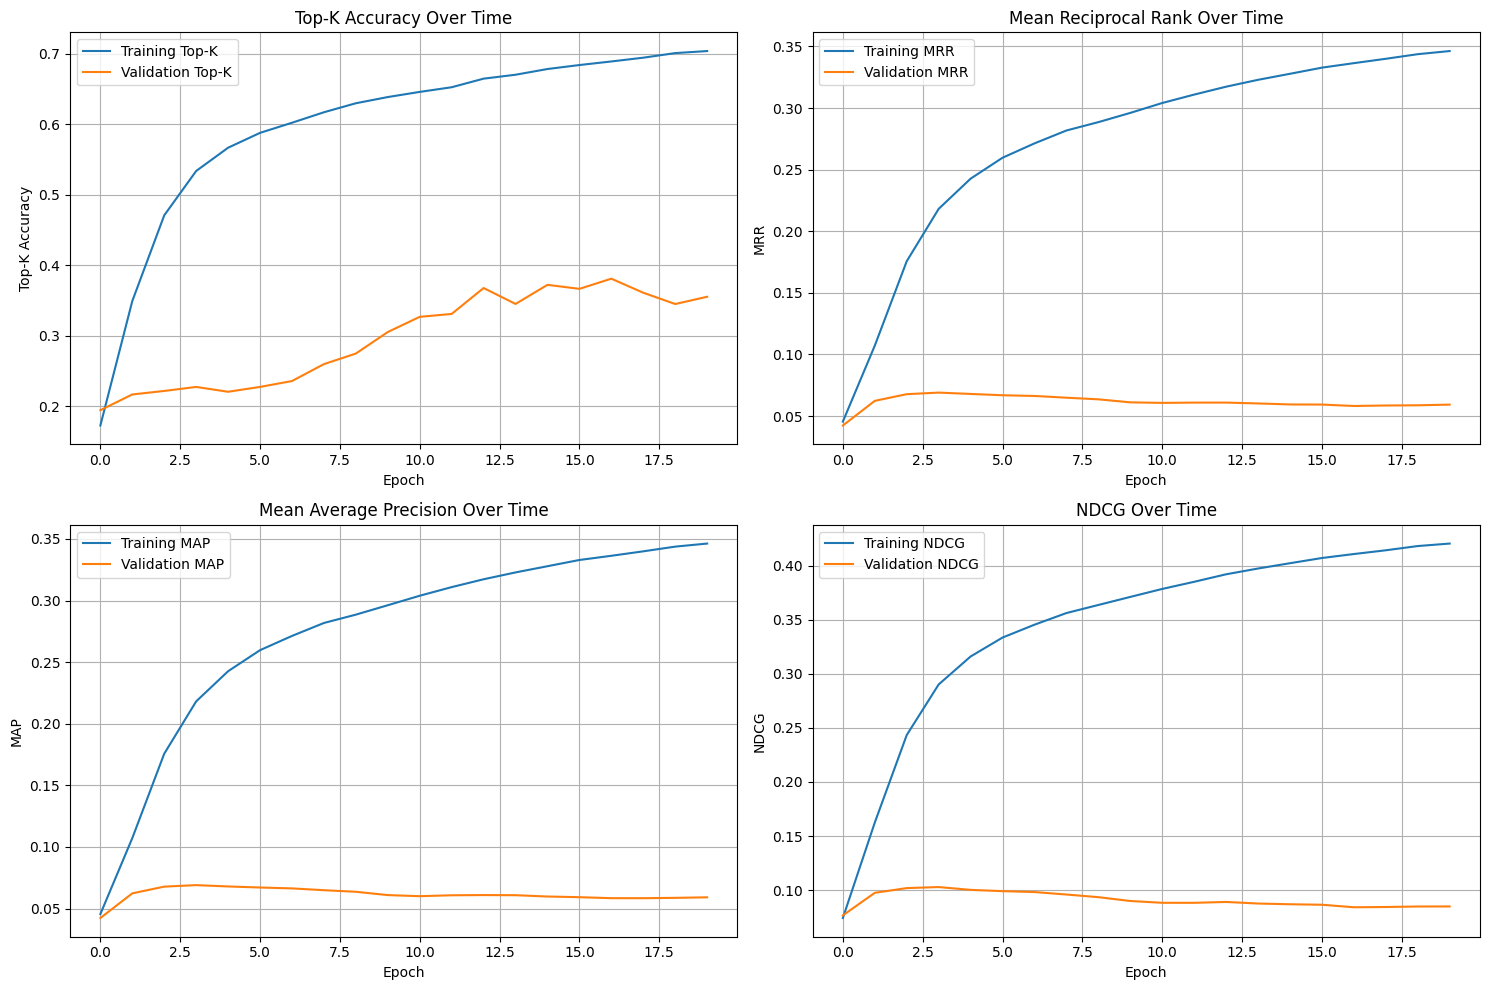

Final Training Metrics:


,Metric,Value
0,Top-10 Accuracy,0.703516
1,MRR@10,0.346286
2,MAP@10,0.346256
3,NDCG@10,0.420444



Final Validation Metrics:


,Metric,Value
0,Top-10 Accuracy,0.355245
1,MRR@10,0.059259
2,MAP@10,0.059085
3,NDCG@10,0.084923


In [27]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['top_k_accuracy'], label='Training Top-K')
plt.plot(history.history['val_top_k_accuracy'], label='Validation Top-K')
plt.title('Top-K Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Top-K Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history.history['mrr'], label='Training MRR')
plt.plot(history.history['val_mrr'], label='Validation MRR')
plt.title('Mean Reciprocal Rank Over Time')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history.history['map'], label='Training MAP')
plt.plot(history.history['val_map'], label='Validation MAP')
plt.title('Mean Average Precision Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAP')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history.history['ndcg'], label='Training NDCG')
plt.plot(history.history['val_ndcg'], label='Validation NDCG')
plt.title('NDCG Over Time')
plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

train_metrics = {
    'Metric': [
        f"Top-{recommender_system.retrieval_k} Accuracy",
        f"MRR@{recommender_system.retrieval_k}",
        f"MAP@{recommender_system.retrieval_k}",
        f"NDCG@{recommender_system.retrieval_k}"
    ],
    'Value': [
        history.history['top_k_accuracy'][-1],
        history.history['mrr'][-1],
        history.history['map'][-1],
        history.history['ndcg'][-1]
    ]
}

val_metrics = {
    'Metric': [
        f"Top-{recommender_system.retrieval_k} Accuracy",
        f"MRR@{recommender_system.retrieval_k}",
        f"MAP@{recommender_system.retrieval_k}",
        f"NDCG@{recommender_system.retrieval_k}"
    ],
    'Value': [
        history.history['val_top_k_accuracy'][-1],
        history.history['val_mrr'][-1],
        history.history['val_map'][-1],
        history.history['val_ndcg'][-1]
    ]
}

train_df = pd.DataFrame(train_metrics)
val_df = pd.DataFrame(val_metrics)

print("Final Training Metrics:")
display(train_df)

print("\nFinal Validation Metrics:")
display(val_df)

In [28]:
test_metrics = recommender_system.evaluate(test_dataset, verbose=1)


354/354 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 494607904.0000 - map: 0.0586 - mrr: 0.0587 - ndcg: 0.0841 - top_k_accuracy: 0.3720


In [29]:
item_mapping = df[['item', 'item_descrip']].drop_duplicates().set_index('item')['item_descrip'].to_dict()

def display_user_history(user_id):
    user_history = df[df['id'] == user_id].sort_values('month')
    print(f"\nUser {user_id} interaction history:")
    print("-" * 50)
    for _, row in user_history.iterrows():
        print(f"Item: {row['item_descrip']}")
        print(f"Interaction: {'CHECKOUT' if row['interaction'] == 1 else 'CLICK'}")
        print(f"Month: {row['month']:.0f}, Day: {row['day']:.0f}")
        print("-" * 50)

def get_recommendations_for_user(user_id, user_data):
    user_id_tensor = user_id_lookup(tf.constant([int(user_id)]))
    
    user_features = {
        'user_id': user_id_tensor,
        'active_ind': tf.constant([[user_data['active_ind']]], dtype=tf.int32),
        'segment': tf.constant([[user_data['segment']]], dtype=tf.int32),
        'beh_segment': tf.constant([[user_data['beh_segment']]], dtype=tf.int32),
        'tod': tf.constant([[user_data['tod']]], dtype=tf.int32),
        'page': tf.constant([[user_data['page']]], dtype=tf.int32),
        'day': tf.constant([[user_data['day']]], dtype=tf.float32),
        'day_of_week': tf.constant([[user_data['day_of_week']]], dtype=tf.float32),
        'month': tf.constant([[user_data['month']]], dtype=tf.float32)
    }
    
    recommender_system.update_candidates(candidate_dataset)
    
    try:
        recommendations = recommender_system(user_features)
        return recommendations['predictions'][0], recommendations['scores'][0]
    except Exception as e:
        print(f"Error getting recommendations: {str(e)}")
        return [], []

In [37]:
user_interactions = df.groupby('id').agg({
    'interaction': 'count',
    'item': 'nunique',
    'segment': 'first',
    'beh_segment': 'first',
    'active_ind': 'first'
}).reset_index()

active_users = user_interactions[
    (user_interactions['interaction'] >= 5) & 
    (user_interactions['segment'].notna())
]

print(f"Found {len(active_users)} active users across {active_users['segment'].nunique()} segments")

segment_users = {}
for segment in sorted(active_users['segment'].unique()):
    segment_users[segment] = active_users[active_users['segment'] == segment].iloc[0]['id']

segment_results = []
for segment, user_id in list(segment_users.items()):  
    user_profile = active_users[active_users['id'] == user_id].iloc[0]
    user_data = df[df['id'] == user_id].iloc[-1].to_dict()
    prev_items = df[df['id'] == user_id].sort_values(['month', 'day'])[['item', 'item_descrip', 'interaction']]
    prev_items_df = prev_items.drop_duplicates(['item', 'interaction'])[['item_descrip', 'interaction']]
    prev_items_df = prev_items_df.rename(columns={'item_descrip': 'Previously Interacted Item', 'interaction': 'Interaction Type'})
    prev_items_df['Interaction Type'] = prev_items_df['Interaction Type'].map({0: 'CLICK', 1: 'CHECKOUT'})
    recommended_items, scores = get_recommendations_for_user(user_id, user_data)
    recs = []
    for idx, (item_idx, score) in enumerate(zip(recommended_items[:10], scores[:10]), 1):
        item_id = item_id_lookup.get_vocabulary()[item_idx]
        recs.append({
            'Rank': idx,
            'Item': item_mapping.get(item_id, "Unknown Item"),
            'Confidence Score': float(score)
        })
    segment_results.append({
        'Segment': segment,
        'User ID': user_id,
        'Total Interactions': user_profile['interaction'],
        'Unique Items Viewed': user_profile['item'],
        'Behavioral Segment': user_profile['beh_segment'],
        'Activity Status': 'Active' if user_profile['active_ind'] == 1 else 'Inactive',
        'Previous Items': prev_items_df,
        'Recommendations': recs
    })

summary_df = pd.DataFrame([
    {
        'Segment': r['Segment'],
        'User ID': r['User ID'],
        'Total Interactions': r['Total Interactions'],
        'Unique Items Viewed': r['Unique Items Viewed'],
        'Behavioral Segment': r['Behavioral Segment'],
        'Activity Status': r['Activity Status']
    }
    for r in segment_results
])

from IPython.display import display
display(summary_df)

for r in segment_results:
    display(r['Previous Items'])
    recs_df = pd.DataFrame(r['Recommendations'])
    display(recs_df)

Found 15155 active users across 4 segments


,Segment,User ID,Total Interactions,Unique Items Viewed,Behavioral Segment,Activity Status
0,0,28951,19,8,6,Inactive
1,1,49398,5,2,1,Inactive
2,2,55558,5,2,17,Inactive
3,3,78336,18,8,0,Inactive


,Previously Interacted Item,Interaction Type
11893,DDA TEMP LOANS BATCH,CHECKOUT
11894,DDA TEMP LOANS BATCH,CLICK
23812,POWERBALL,CHECKOUT
23814,SMART DEVICE OFFER,CHECKOUT
23815,MONEY MANAGEMENT_SENDMONE,CLICK
40918,ZFN LIM INCREASE,CHECKOUT
40919,ZFN LIM INCREASE,CLICK
40920,PLS NEW LOAN,CHECKOUT
56370,COVER YOUR WHOLE FAMILY,CLICK
122388,SMART SPEND,CHECKOUT


,Rank,Item,Confidence Score
0,1,EBUCKS EXTRAMARKS,0.420391
1,2,SELF EMPLOYED BUNDLE,0.369790
2,3,ZFN CARD UPGRADE,0.353290
3,4,EBUCKS UDEMY,0.342977
4,5,SMART SPEND,0.342851
5,6,RF LIMIT INCREASE,0.342123
6,7,HOMELOANS GENERIC MESSAGE,0.320187
7,8,RETIREMENT ANNUITY,0.290589
8,9,ISB UPRGADES,0.266678
9,10,TAX FREE DEPOSIT,0.256327


,Previously Interacted Item,Interaction Type
8499,LIFE SIMPLI,CHECKOUT
8500,LIFE SIMPLI,CLICK
194766,PLS NEW LOAN,CHECKOUT
194768,PLS NEW LOAN,CLICK


,Rank,Item,Confidence Score
0,1,Unknown Item,8.443092
1,2,CELLPHONE TOP UP DATA,7.400019
2,3,ZFN LIM INCREASE,4.809594
3,4,FUSION CARD SWOP,4.584145
4,5,PREPAID ELECTRICITY,3.680414
5,6,LIFE SIMPLI,3.542239
6,7,MONEY COACH,3.276695
7,8,EBUCKS GUARD ME,2.948840
8,9,DDA TEMP LOANS BATCH,2.782692
9,10,GOOGLE WALLET,2.093078


,Previously Interacted Item,Interaction Type
65626,EBUCKS EARN MORE,CLICK
65627,EBUCKS EARN MORE,CHECKOUT
99732,MONEY COACH,CLICK
99733,MONEY COACH,CHECKOUT


,Rank,Item,Confidence Score
0,1,INCREASE FUNERAL COVER,5.694284
1,2,EBUCKS EARN MORE,5.556213
2,3,DYNAMIC LIFE HOME COVER,5.256155
3,4,GENERIC MESSAGE,5.114913
4,5,CELLPHONE TALK MAX TOP UP,4.881382
5,6,FUNERAL COVER,4.233113
6,7,EBUCKS GUARD ME,3.853709
7,8,MONEY COACH,3.783023
8,9,EBUCKS QUICK BUS,3.779925
9,10,CELLPHONE TOP UP DATA,3.452443


,Previously Interacted Item,Interaction Type
38090,ZFN LIM INCREASE,CLICK
38091,ZFN LIM INCREASE,CHECKOUT
77437,TAX FREE DEPOSIT,CHECKOUT
77438,TAX FREE DEPOSIT,CLICK
85762,LIFE INSURANCE SWITCH,CLICK
85763,GENERIC MESSAGE,CLICK
87757,REVOLVING FACILITY,CHECKOUT
87758,SMART DEVICE OFFER,CHECKOUT
87759,SMART DEVICE OFFER,CLICK
129162,PLS NEW LOAN,CHECKOUT


,Rank,Item,Confidence Score
0,1,Unknown Item,0.0
1,2,DELIGHT FUEL OFFER,0.0
2,3,WEALTH ADVISOR SOLUTION,0.0
3,4,SELF EMPLOYED BUNDLE,0.0
4,5,TYRE AND RIM,0.0
5,6,SCRATCH AND DENT,0.0
6,7,FIRST WARANTY,0.0
7,8,NAV CREDIT STATUS DAILY,0.0
8,9,MONEY MANAGEMENT_SENDMONE,0.0
9,10,MONEY COACH,0.0
